#### About

resnet50 with progressive resizing: 224 -> 512
- SOTA is 90.52%: https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/
- Other results: https://github.com/stratospark/food-101-keras


#### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split('|')[0])

fastai: 1.0.45
pytorch: 1.0.0
python: 3.6.5 


#### Examine dataset file structure

In [3]:
# download the dataset
! mkdir -p /home/ubuntu/.fastai/data; 
! cd /home/ubuntu/.fastai/data; wget -nc http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz; tar xf food-101.tar.gz

--2019-02-14 19:30:07--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-02-14 19:30:07--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  6.50MB/s    in 11m 28s 

2019-02-14 19:41:35 (6.93 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [4]:
path=Path('/home/ubuntu/.fastai/data/food-101')

In [5]:
# see what files we've got
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/food-101/images'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/meta'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/license_agreement.txt'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/README.txt')]

In [6]:
Path(path/'images').ls()[:5]

[PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/clam_chowder'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/cheesecake'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/gnocchi'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/escargots')]

In [7]:
# show some sample paths to the images
get_image_files(path/'images/foie_gras')[:5]

[PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/347577.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/1146464.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/2944644.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/1981572.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/food-101/images/foie_gras/2325009.jpg')]

In [17]:
# see how many files in each category
for dirname in os.listdir(path/'images'):
    print(dirname, len(os.listdir(path/'images'/dirname)))

foie_gras 1000
clam_chowder 1000
cheesecake 1000
gnocchi 1000
escargots 1000
ceviche 1000
cannoli 1000
ice_cream 1000
pancakes 1000
croque_madame 1000
caprese_salad 1000
caesar_salad 1000
hot_dog 1000
spaghetti_carbonara 1000
breakfast_burrito 1000
greek_salad 1000
french_onion_soup 1000
bread_pudding 1000
onion_rings 1000
baklava 1000
tiramisu 1000
bibimbap 1000
omelette 1000
dumplings 1000
macarons 1000
beignets 1000
sashimi 1000
waffles 1000
pad_thai 1000
prime_rib 1000
eggs_benedict 1000
gyoza 1000
crab_cakes 1000
fish_and_chips 1000
sushi 1000
lobster_bisque 1000
huevos_rancheros 1000
pulled_pork_sandwich 1000
chicken_wings 1000
french_fries 1000
spaghetti_bolognese 1000
samosa 1000
oysters 1000
strawberry_shortcake 1000
tuna_tartare 1000
panna_cotta 1000
scallops 1000
pizza 1000
takoyaki 1000
hot_and_sour_soup 1000
macaroni_and_cheese 1000
falafel 1000
chocolate_cake 1000
chicken_quesadilla 1000
poutine 1000
cup_cakes 1000
pork_chop 1000
lasagna 1000
ravioli 1000
peking_duck 1000

#### Examine image size distribution

torch.Size([3, 382, 512])


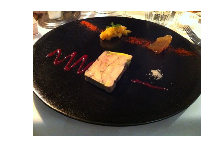

In [18]:
# look the shape and visualize one image
img = open_image(get_image_files(path/'images/foie_gras')[0])
print(img.shape)
img.show()

In [19]:
# calculate average, minimum, and maximum for width and height of images
widths, heights = [], []
width_min, width_max = np.inf, -np.inf
height_min, height_max = np.inf, -np.inf

for dirname in os.listdir(path/'images'):
    for filename in os.listdir(path/'images'/dirname):
        image = PIL.Image.open(os.path.join(path/'images'/dirname, filename))
        widths.append(image.size[0])
        heights.append(image.size[1])

print('avg (width, height): ', (np.mean(widths), np.mean(heights)))
print('std (width, height): ', (np.std(widths), np.std(heights)))
print('width (min, max): ', (np.min(widths), np.max(widths)))
print('height (min, max): ', (np.min(heights), np.max(heights)))

avg (width, height):  (495.79139603960397, 475.3721287128713)
std (width, height):  (45.67412139905732, 65.30544596506714)
width (min, max):  (193, 512)
height (min, max):  (122, 512)


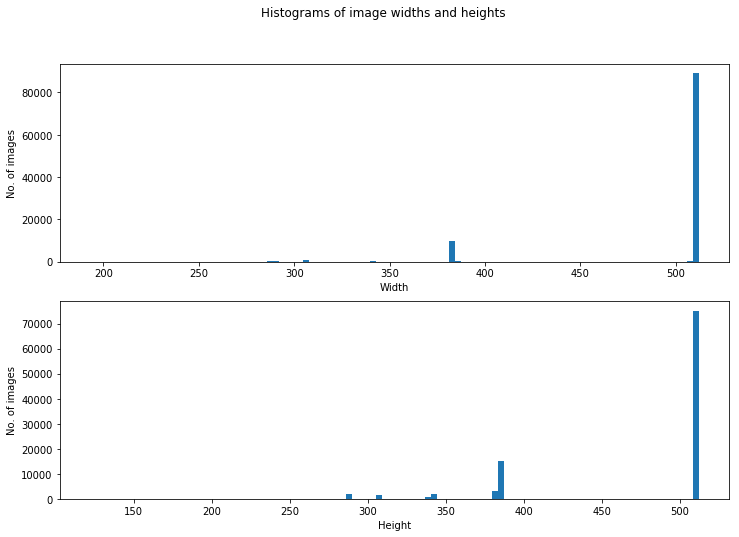

In [20]:
# plot histograms of heights and widths.
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of image widths and heights')
 
ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')
 
plt.show()

#### Generate files to use in datablock

In [126]:
# csv file with labels aggregating train and test sets
out_file = open(path/'images/labels.csv', 'w')
out_file.write('path,label\n')
with open(path/'meta/train.txt') as f:
  for line in f:
    parts = line.split('/')
    line_out = line.strip('\n') + '.jpg' + ',' + parts[0] + '\n'
    out_file.write(line_out)
with open(path/'meta/test.txt') as f:
  for line in f:
    parts = line.split('/')
    line_out = line.strip('\n') + '.jpg' + ',' + parts[0] + '\n'
    out_file.write(line_out)
out_file.close()

# list of filenames in the test set
out_file = open(path/'images/test.txt', 'w')
with open(path/'meta/test.txt') as f:
  for line in f:
    parts = line.split('/')
    line_out = parts[1].strip('\n') + '.jpg' + '\n'
    out_file.write(line_out)
out_file.close()

#### Create datablock

In [118]:
# set hyperparamters
np.random.seed(42)
size = 224
bs = 64
num_workers = 4

In [6]:
# define data augmentation transformations
tfms = get_transforms()

In [7]:
# use the labeled test data as the validation set
src = (ImageItemList.from_csv(path/'images', csv_name='labels.csv')
       .split_by_fname_file('test.txt')
       .label_from_df())

In [128]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

#### Do sanity checks

In [129]:
# verify datasets loaded properly
print(len(data.train_ds))
print(len(data.valid_ds))

75750
25250


In [130]:
data.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

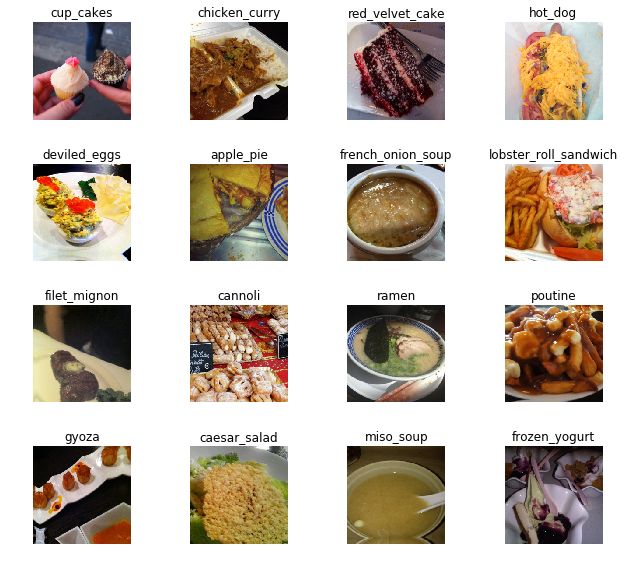

In [131]:
data.show_batch(rows=4, figsize=(9,8))

#### Create model

In [5]:
# define architecture
arch = models.resnet50

In [133]:
# create learner
learn = create_cnn(data, arch, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 60682534.01it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


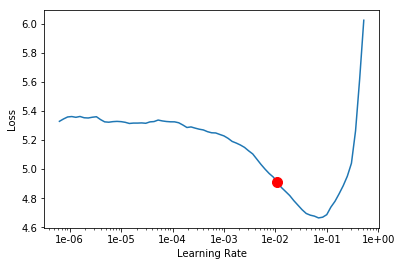

In [134]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [135]:
lr = 1.1e-2

## size 224

#### Train on frozen model

In [136]:
# first fit the head of the model
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,1.900321,1.316975,0.639842
2,1.716312,1.162047,0.679446
3,1.597668,1.053836,0.705822
4,1.449502,0.967239,0.728238
5,1.323515,0.844721,0.764554
6,1.169906,0.755831,0.787802
7,1.058801,0.706954,0.800832
8,0.997801,0.698707,0.804792


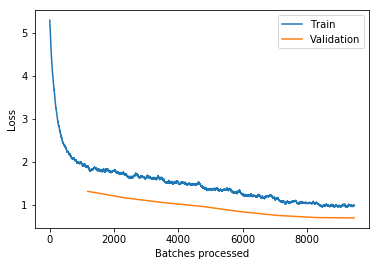

In [137]:
learn.recorder.plot_losses()

In [138]:
learn.save('stage-1')

#### Train on unfrozen model

In [139]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


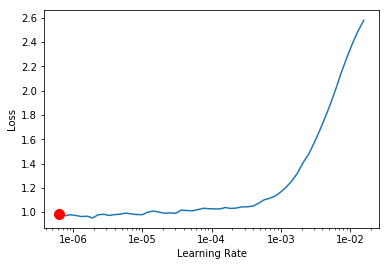

In [140]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [141]:
# now fit across the entire model
learn.fit_one_cycle(3, max_lr=slice(6.31e-7, 3e-5))

epoch,train_loss,valid_loss,accuracy
1,0.998108,0.684177,0.807485
2,0.950805,0.665903,0.813861
3,0.933739,0.664527,0.813465


In [142]:
learn.save('stage-2')

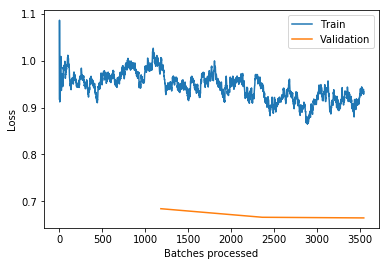

In [143]:
learn.recorder.plot_losses()

#### Look at results

In [144]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

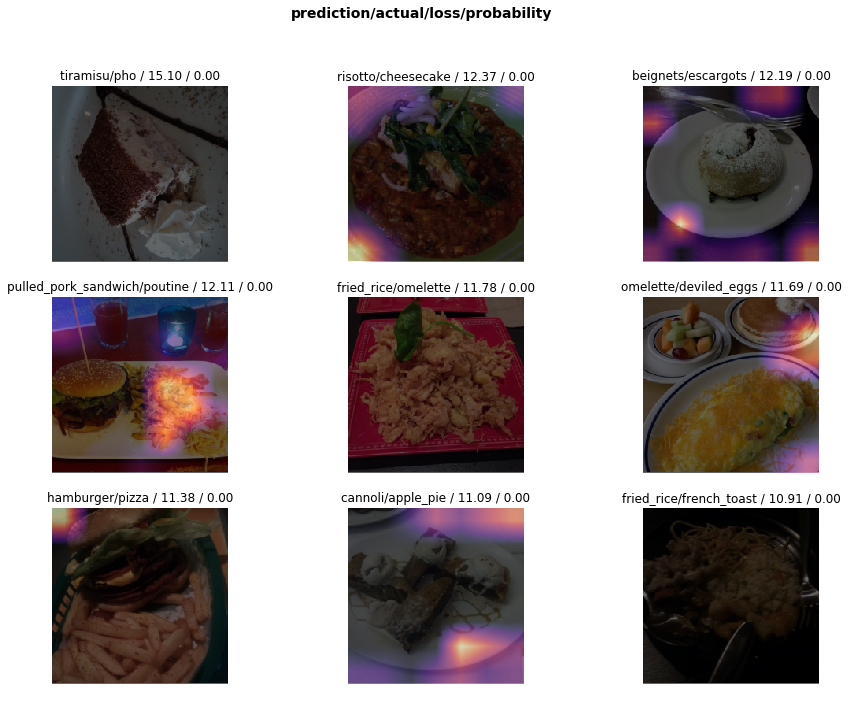

In [145]:
interp.plot_top_losses(9, figsize=(15,11))

In [148]:
interp.most_confused(min_val=15)

[('steak', 'filet_mignon', 47),
 ('filet_mignon', 'steak', 31),
 ('tuna_tartare', 'beef_tartare', 25),
 ('apple_pie', 'bread_pudding', 22),
 ('beef_tartare', 'tuna_tartare', 22),
 ('chocolate_cake', 'chocolate_mousse', 22),
 ('pork_chop', 'steak', 21),
 ('pork_chop', 'filet_mignon', 20),
 ('chocolate_mousse', 'chocolate_cake', 19),
 ('steak', 'prime_rib', 19),
 ('baby_back_ribs', 'steak', 17),
 ('pork_chop', 'grilled_salmon', 17),
 ('club_sandwich', 'grilled_cheese_sandwich', 16),
 ('falafel', 'crab_cakes', 16),
 ('prime_rib', 'steak', 16)]

In [175]:
# print accuracy
correct_preds = interp.pred_class == interp.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.8134653465346534

#### Look at results with TTA

In [176]:
interp_tta = ClassificationInterpretation.from_learner(learn, tta=True)
losses,idxs = interp_tta.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

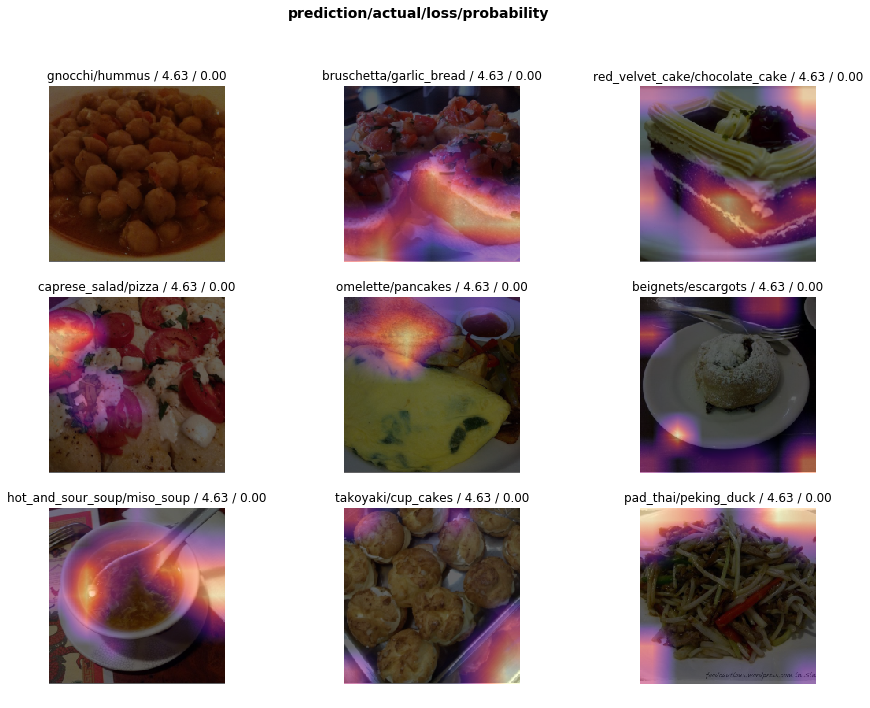

In [177]:
interp_tta.plot_top_losses(9, figsize=(15,11))

In [178]:
interp_tta.most_confused(min_val=15)

[('steak', 'filet_mignon', 42),
 ('filet_mignon', 'steak', 32),
 ('apple_pie', 'bread_pudding', 26),
 ('chocolate_mousse', 'chocolate_cake', 23),
 ('pork_chop', 'grilled_salmon', 22),
 ('beef_tartare', 'tuna_tartare', 21),
 ('chocolate_cake', 'chocolate_mousse', 20),
 ('bread_pudding', 'apple_pie', 19),
 ('club_sandwich', 'grilled_cheese_sandwich', 19),
 ('tuna_tartare', 'beef_tartare', 19),
 ('pork_chop', 'filet_mignon', 18),
 ('ice_cream', 'chocolate_mousse', 17),
 ('tiramisu', 'chocolate_mousse', 17),
 ('falafel', 'crab_cakes', 16),
 ('steak', 'prime_rib', 16)]

In [179]:
# print accuracy
correct_preds = interp_tta.pred_class == interp_tta.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.8288316831683168

## size 512

In [8]:
# set hyperparamters
np.random.seed(42)
size = 512
bs = 24
num_workers = 4

In [9]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [10]:
learn = create_cnn(data, arch, metrics=accuracy).load('stage-2')

In [11]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


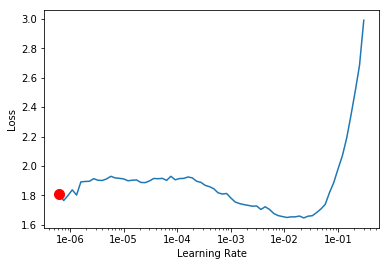

In [12]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [13]:
lr = 5e-3

#### Train on frozen model

In [14]:
# first fit the head of the model
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,1.070553,0.677099,0.809228
2,1.178155,0.700136,0.804238
3,1.244714,0.688086,0.808079
4,1.154610,0.647540,0.817545
5,1.059964,0.606669,0.829782
6,0.876727,0.567050,0.839446
7,0.859235,0.526975,0.850851
8,0.756354,0.523432,0.852158


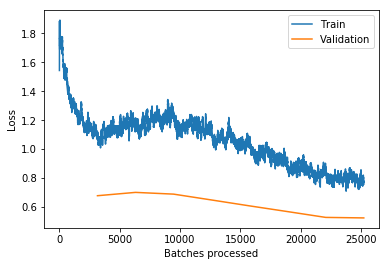

In [15]:
learn.recorder.plot_losses()

In [16]:
learn.save('stage-3')

#### Train on unfrozen model

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


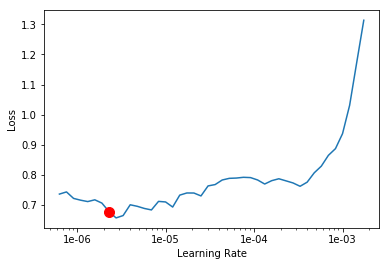

In [18]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [19]:
# now fit across the entire model
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.794853,0.514827,0.852594
2,0.745092,0.503388,0.858218
3,0.737689,0.501558,0.857980


In [20]:
learn.save('stage-4')

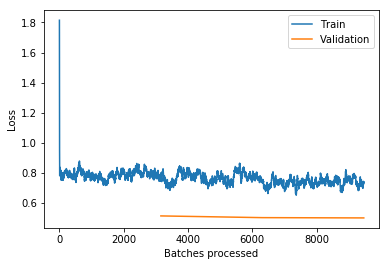

In [21]:
learn.recorder.plot_losses()

#### Look at results

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

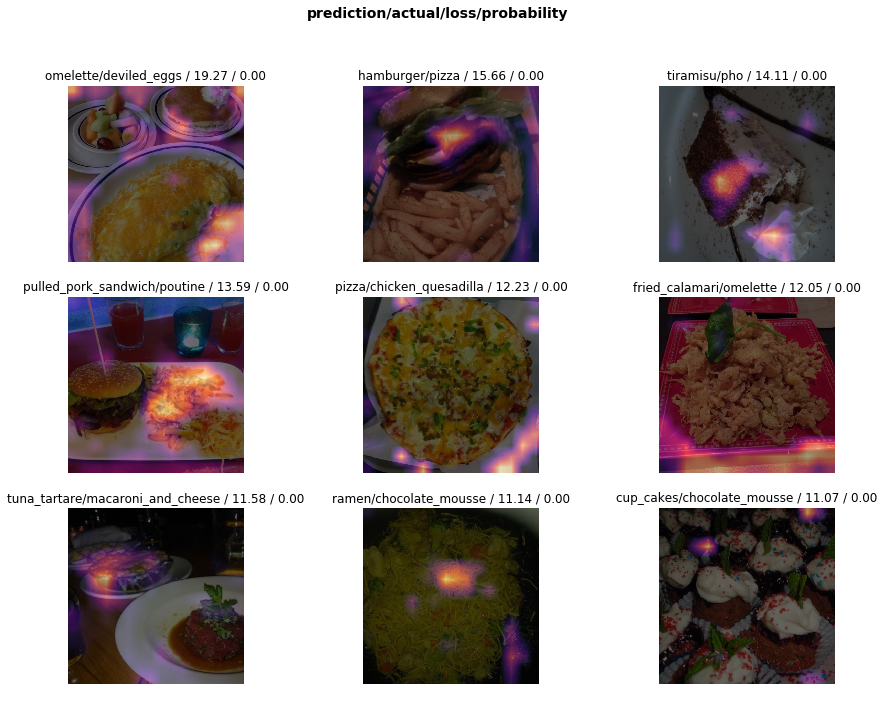

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [24]:
interp.most_confused(min_val=15)

[('steak', 'filet_mignon', 42),
 ('chocolate_cake', 'chocolate_mousse', 28),
 ('chocolate_mousse', 'chocolate_cake', 28),
 ('filet_mignon', 'steak', 28),
 ('pork_chop', 'filet_mignon', 27),
 ('prime_rib', 'steak', 24),
 ('pork_chop', 'steak', 22),
 ('bread_pudding', 'apple_pie', 19),
 ('tuna_tartare', 'beef_tartare', 19),
 ('apple_pie', 'bread_pudding', 18),
 ('beef_tartare', 'tuna_tartare', 18)]

#### Look at results with TTA

In [25]:
interp_tta = ClassificationInterpretation.from_learner(learn, tta=True)
losses,idxs = interp_tta.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

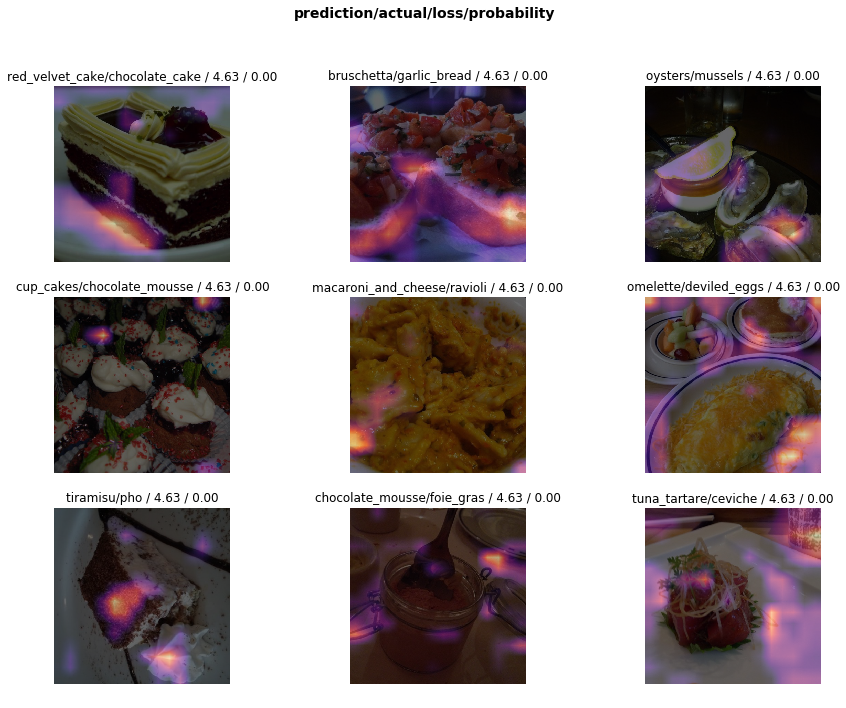

In [26]:
interp_tta.plot_top_losses(9, figsize=(15,11))

In [27]:
interp_tta.most_confused(min_val=15)

[('steak', 'filet_mignon', 37),
 ('filet_mignon', 'steak', 33),
 ('prime_rib', 'steak', 27),
 ('chocolate_mousse', 'chocolate_cake', 25),
 ('chocolate_cake', 'chocolate_mousse', 22),
 ('pork_chop', 'filet_mignon', 22),
 ('tuna_tartare', 'beef_tartare', 21),
 ('pork_chop', 'grilled_salmon', 19),
 ('pork_chop', 'steak', 19),
 ('bread_pudding', 'apple_pie', 18),
 ('apple_pie', 'bread_pudding', 17),
 ('club_sandwich', 'grilled_cheese_sandwich', 17),
 ('beef_tartare', 'tuna_tartare', 16)]